In [ ]:
import ast
import numpy as np
import time
import sys
import pandas as pd
import subprocess
import pickle
import random as rand
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
sns.set()
%config InlineBackend.figure_format='retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Google Colab
%cd "drive/My Drive/internship-2020"

/content/drive/My Drive/internship-2020


### Data Loading

In [ ]:
ratio = len(inv_16) - sum(inv_16), sum(inv_16)
print(ratio)

(659, 32)


In [ ]:
# Simplified rewrite of splitting & oversampling code
from inv16_data_loading import km_normed_1, inv_16

# TESTING: shuffle original label
# np.random.shuffle(inv_16)

# Test split sizes (add up to 1)
train_size = 0.6
valid_size = 0.2
test_size = 0.2

# Separating out negatives & positives
positives = np.array(km_normed_1.iloc[[i for i in range(len(inv_16)) if inv_16[i] == 1]])
negatives = np.array(km_normed_1.iloc[[i for i in range(len(inv_16)) if inv_16[i] == 0]])

# Add randomness to splitting
np.random.shuffle(negatives)
np.random.shuffle(positives)

# Splitting sets
num_pos = len(positives)
num_neg = len(negatives)
sum_sizes = train_size + valid_size + test_size
ps1, ps2 = math.floor(train_size*num_pos), math.floor((train_size+valid_size)*num_pos)
ns1, ns2 = math.floor(train_size*num_neg), math.floor((train_size+valid_size)*num_neg)
train_set = np.concatenate((negatives[:ns1], positives[:ps1]))
valid_set = np.concatenate((negatives[ns1:ns2], positives[ps1:ps2]))
test_set = np.concatenate((negatives[ns2:], positives[ps2:]))
n_neg_train, n_neg_val, n_neg_test = ns1, (ns2-ns1), (num_neg-ns2)
n_pos_train, n_pos_val, n_pos_test = ps1, (ps2-ps1), (num_pos-ps2)
train_label = [0] * n_neg_train + [1] * n_pos_train
valid_label = [0] * n_neg_val + [1] * n_pos_val
test_label = [0] * n_neg_test + [1] * n_pos_test

# TESTING: shuffle after splitting
# rand.shuffle(train_label)
# rand.shuffle(valid_label)
# rand.shuffle(test_label)

# Oversample each set
n_extra_pos_train, n_extra_pos_val, n_extra_pos_test = n_neg_train-n_pos_train, n_neg_val-n_pos_val, n_neg_test-n_pos_test
over_train = np.array([]).reshape((0,km_normed_1.shape[1]))
over_valid = np.array([]).reshape((0,km_normed_1.shape[1]))
over_test = np.array([]).reshape((0,km_normed_1.shape[1]))
i,j,k = 0,0,0
while len(over_train) < n_extra_pos_train:
    over_train = np.concatenate((over_train, train_set[n_neg_train + i % n_pos_train].reshape(1,km_normed_1.shape[1])))
    train_label += [1]
    i += 1
while len(over_valid) < n_extra_pos_val:
    over_valid = np.concatenate((over_valid, valid_set[n_neg_val + j % n_pos_val].reshape(1,km_normed_1.shape[1])))
    valid_label += [1]
    j += 1
while len(over_test) < n_extra_pos_test:
    over_test = np.concatenate((over_test, test_set[n_neg_test + k % n_pos_test].reshape(1,km_normed_1.shape[1])))
    test_label += [1]
    k += 1
oc_train_set = np.concatenate((train_set, over_train))
oc_valid_set = np.concatenate((valid_set, over_valid))
oc_test_set = np.concatenate((test_set, over_test))

# TESTING: shuffle after oversampling
# rand.shuffle(train_label)
# rand.shuffle(valid_label)
# rand.shuffle(test_label)

train_and_label = [(oc_train_set[i],train_label[i]) for i in range(len(train_label))]
valid_and_label = [(oc_valid_set[i],valid_label[i]) for i in range(len(valid_label))]
test_and_label = [(oc_test_set[i],test_label[i]) for i in range(len(test_label))]

# Data samplers & loaders
batch_size = 64
num_workers = 0
train_sampler = SubsetRandomSampler(range(len(train_and_label)))
valid_sampler = SubsetRandomSampler(range(len(valid_and_label)))
test_sampler = SubsetRandomSampler(range(len(test_and_label)))
train_loader = torch.utils.data.DataLoader(train_and_label,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_and_label,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_and_label,
                                           batch_size=batch_size,
                                           sampler=test_sampler,
                                           num_workers=num_workers)

In [ ]:
print(train_set.shape)
print(valid_set.shape)
print(test_set.shape)
print(ns1, ns2, ps1, ps2)
print(len(train_label), len(valid_label), len(test_label))
print(train_label[ns1])

(414, 9995)
(138, 9995)
(139, 9995)
395 527 19 25
790 264 264
1


### Data Visualisation

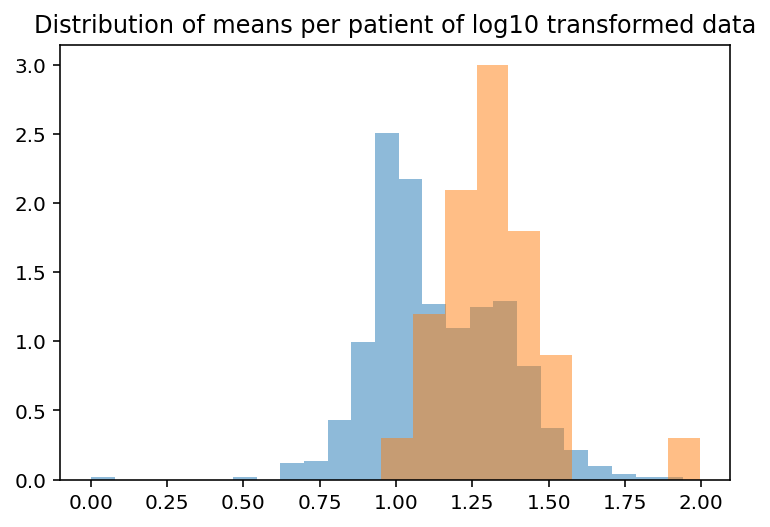

In [ ]:
# Mean per patient of log10 data
from inv16_data_loading import km_flog10, inv_16
positives = np.array(km_flog10.iloc[[i for i in range(len(inv_16)) if inv_16[i] == 1]])
negatives = np.array(km_flog10.iloc[[i for i in range(len(inv_16)) if inv_16[i] == 0]])
plt.hist(np.mean(negatives,axis=1), bins=25, alpha = 0.5, label='negatives', density=True)
plt.hist(np.mean(positives,axis=1), alpha = 0.5, label='positives', density=True)
plt.title("Distribution of means per patient of log10 transformed data")
plt.show()

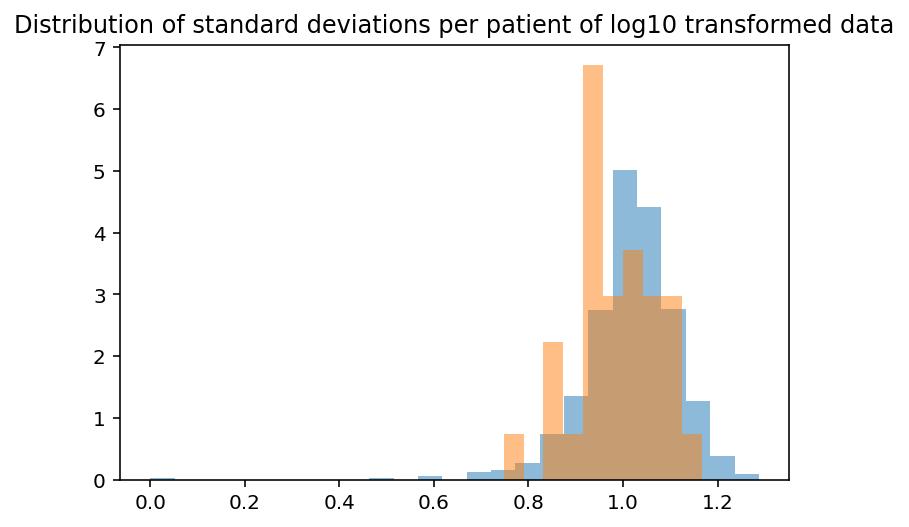

1.0147388374003548 0.9832031575271896


In [ ]:
# std for each patient (log10 data)
a = np.std(negatives,axis=1)
b = np.std(positives,axis=1)
plt.hist(a, bins=25, alpha = 0.5, label='negatives', density=True)
plt.hist(b, alpha = 0.5, label='positives', density=True)
plt.title("Distribution of standard deviations per patient of log10 transformed data")
plt.show()
print(np.mean(a), np.mean(b))

In [ ]:
# testing norm_3
from inv16_data_loading import kmer_table
from transforms import transform_log10, norm_3
temp = norm_3(transform_log10(kmer_table))
positives = np.array(temp.iloc[[i for i in range(len(inv_16)) if inv_16[i] == 1]])
negatives = np.array(temp.iloc[[i for i in range(len(inv_16)) if inv_16[i] == 0]])

In [ ]:
def compare_kmer_plot(i):
    print(i)
    plt.hist(negatives[:,i], bins=100, alpha = 0.5, label='negatives', density=True)
    plt.hist(positives[:,i], bins=25, alpha = 0.5, label='positives', density=True)
    plt.show()

9062


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


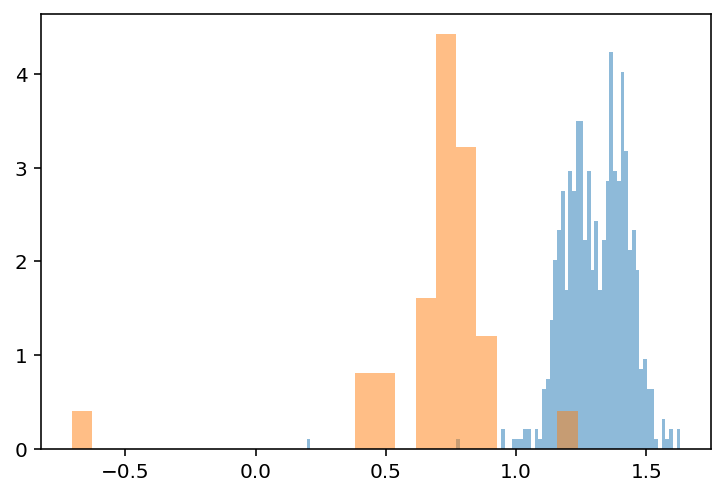

7344


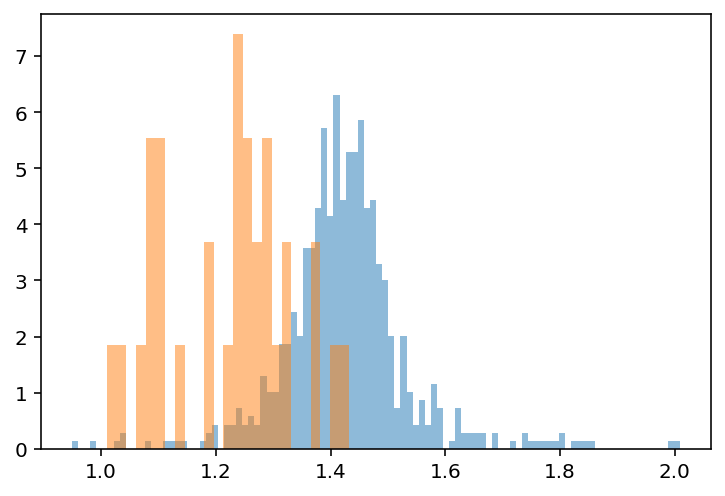

3308


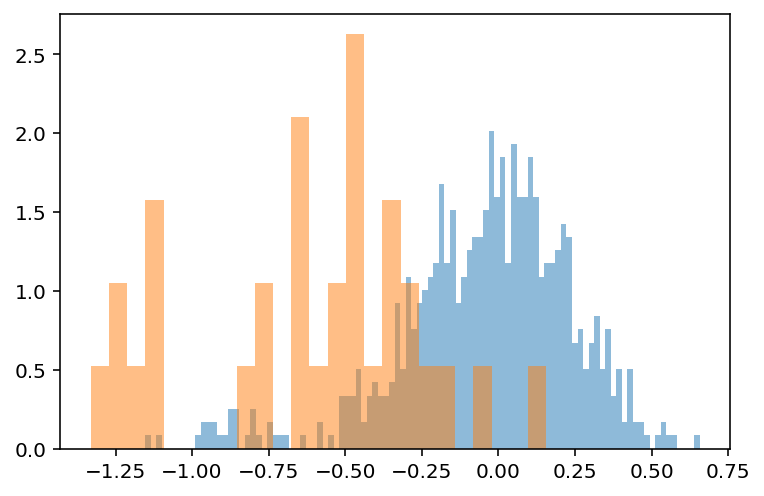

6659


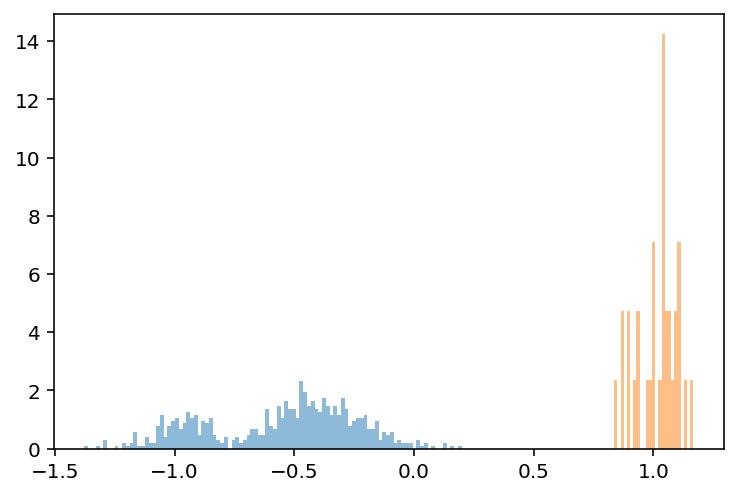

5407


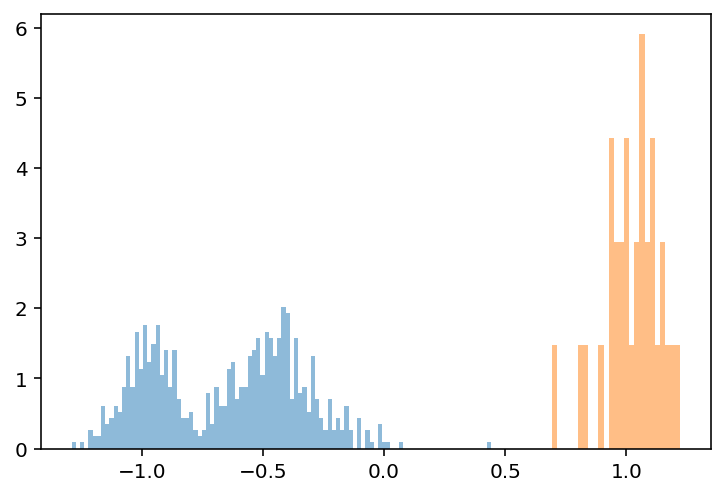

6982


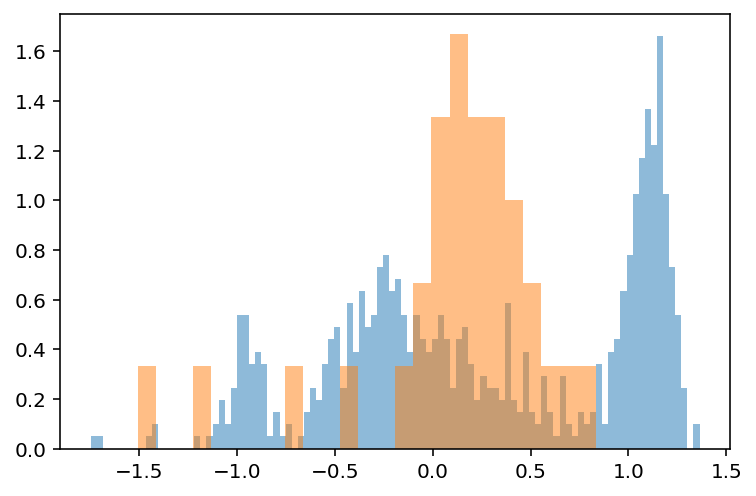

3389


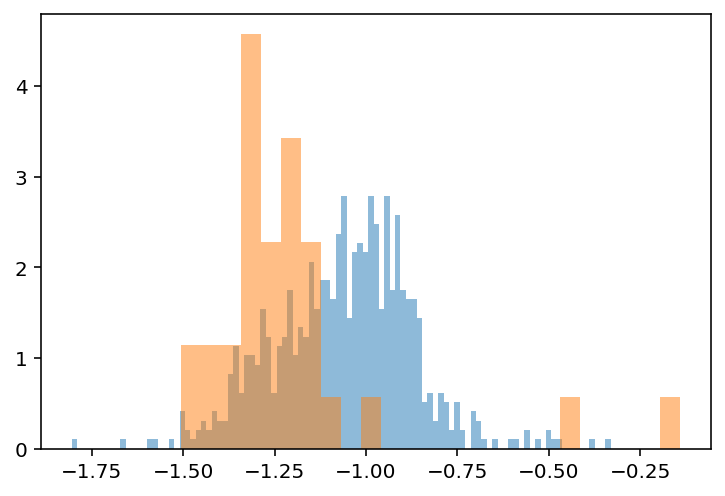

7927


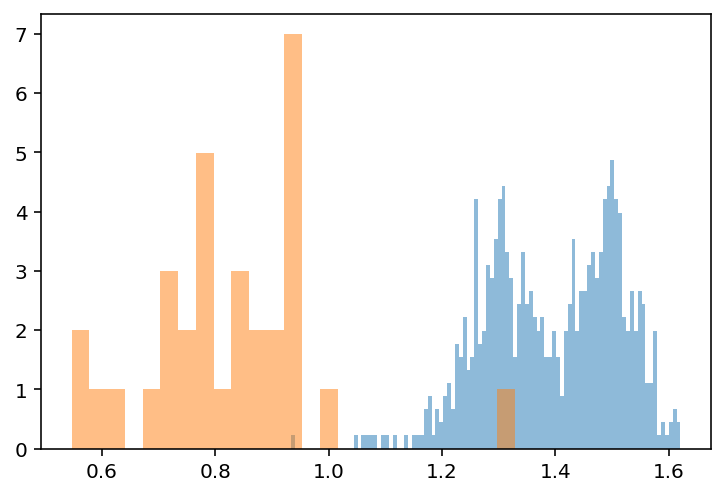

1861


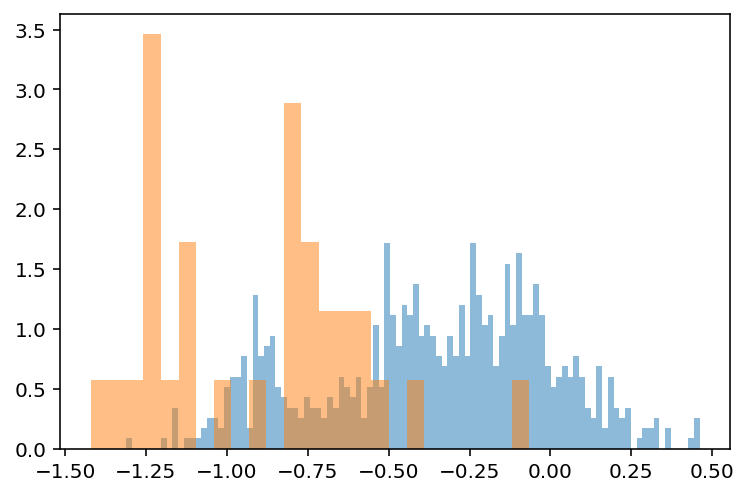

5988


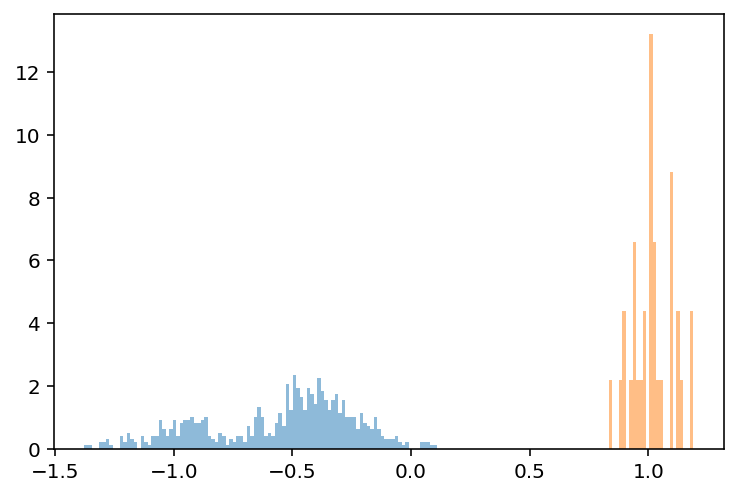

In [ ]:
# Fixed norm 1
for i in range(10):
    compare_kmer_plot(rand.randrange(0,km_normed_1.shape[1]))

1564


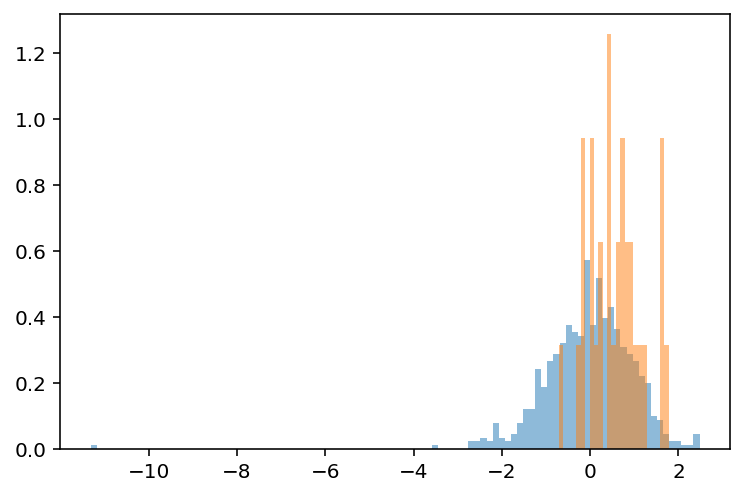

7955


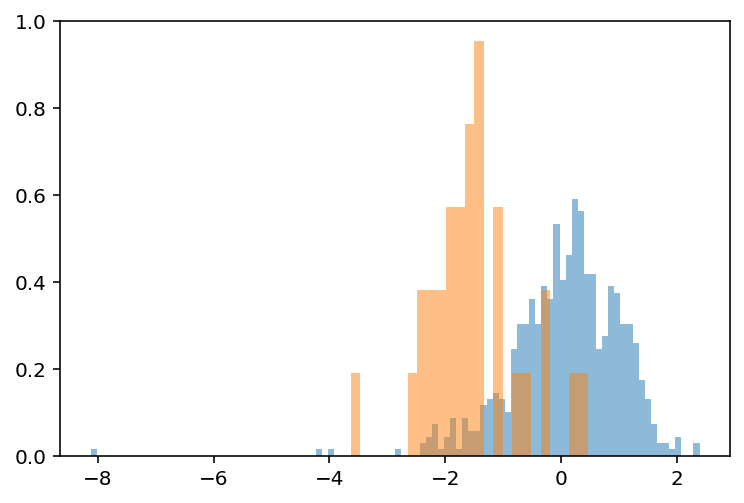

9515


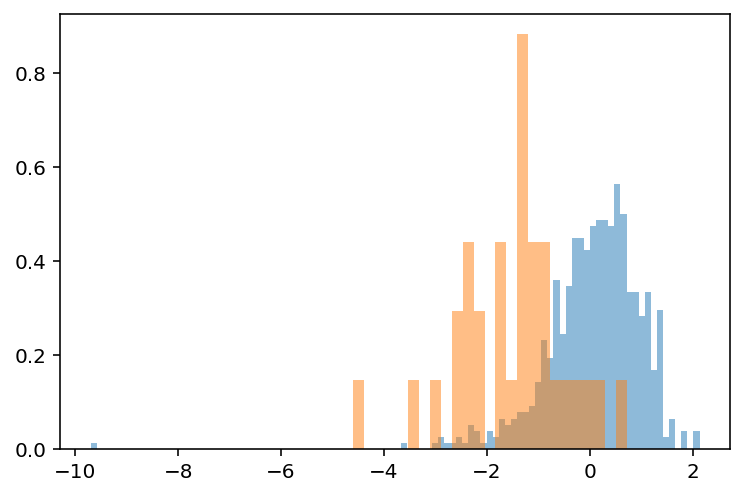

9299


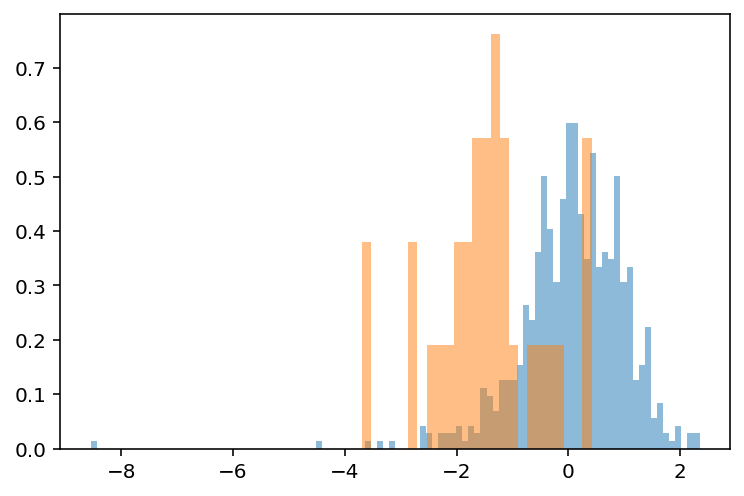

8480


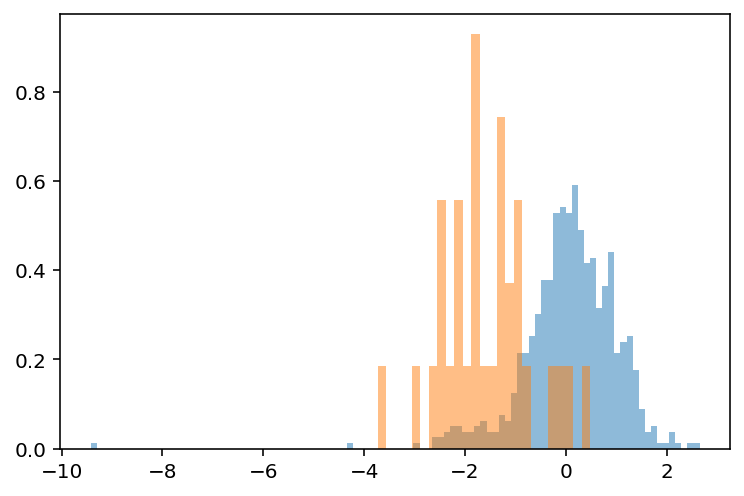

4340


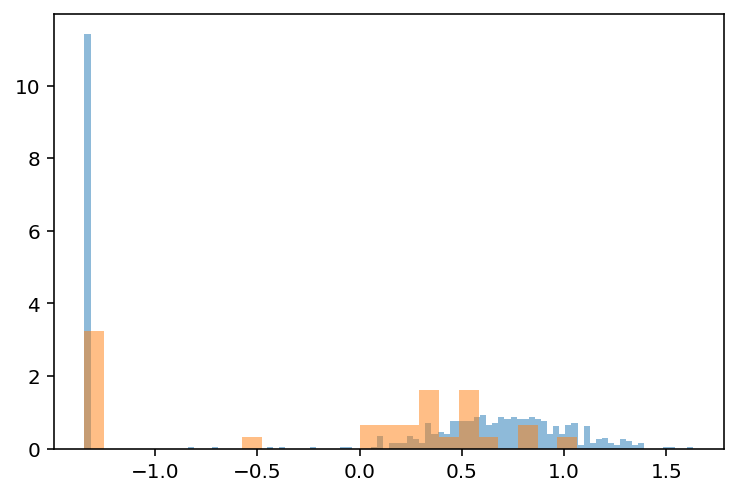

4515


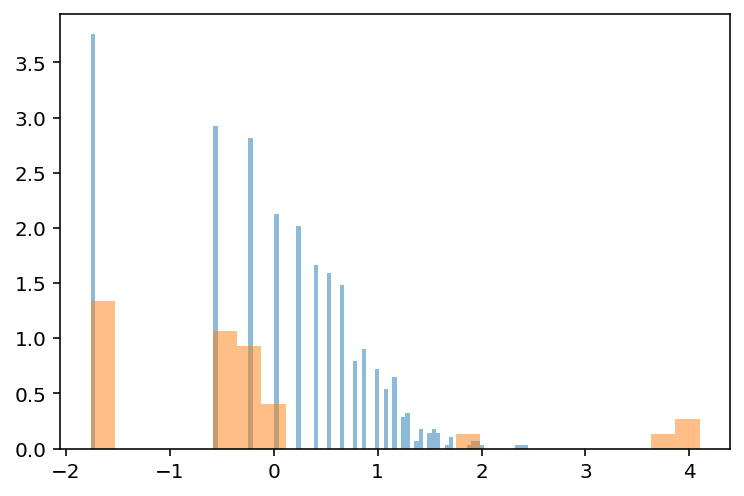

6043


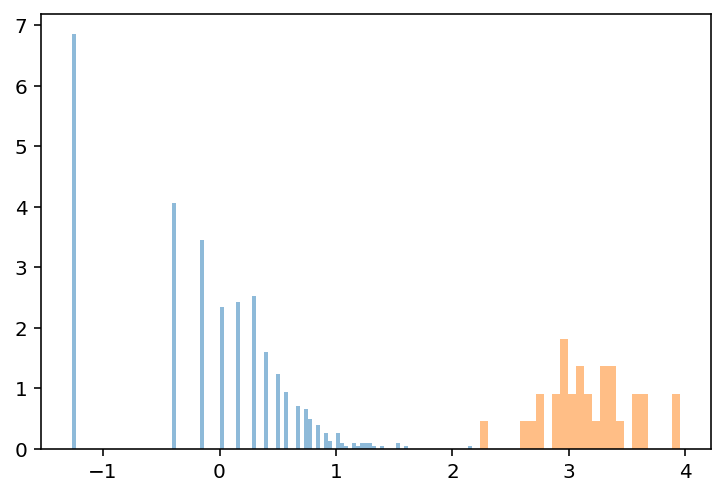

8578


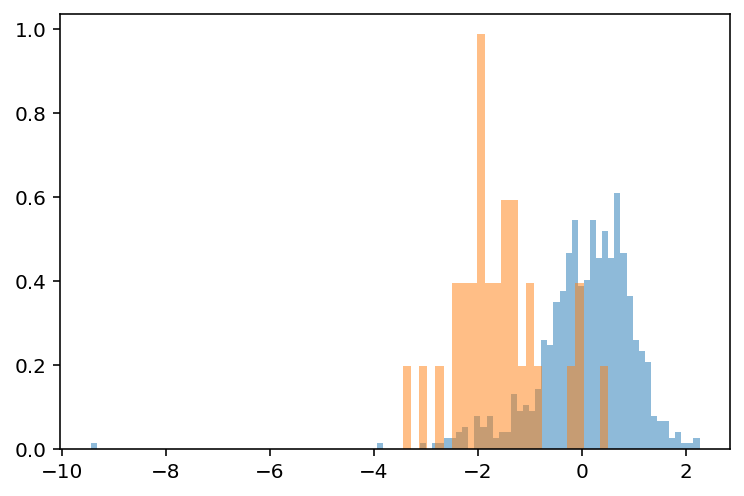

1504


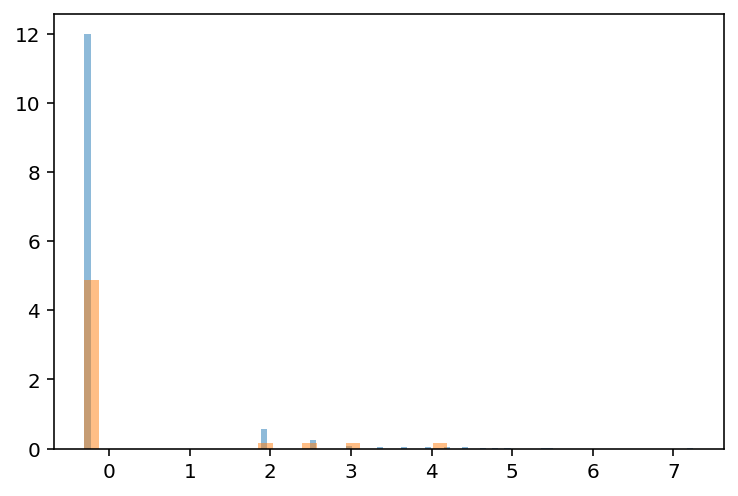

In [ ]:
# norm 2
for i in range(10):
    compare_kmer_plot(rand.randrange(0,km_normed_1.shape[1]))

117


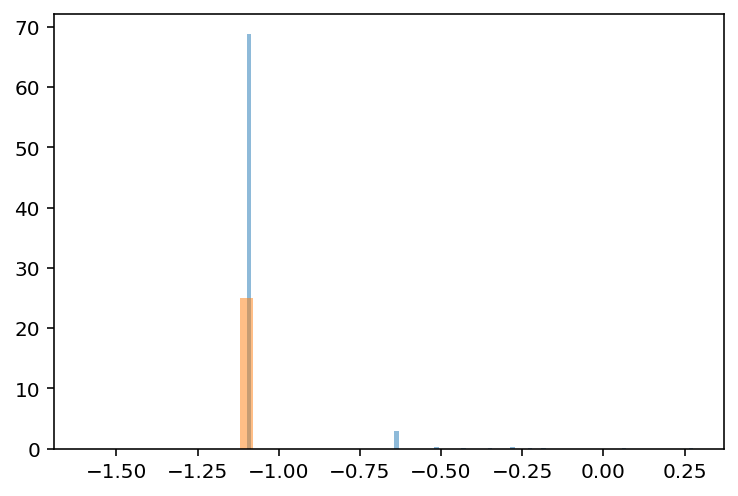

1837


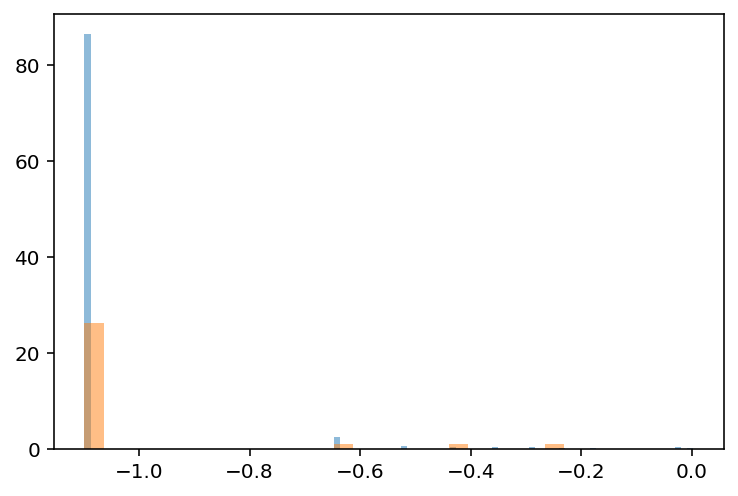

6304


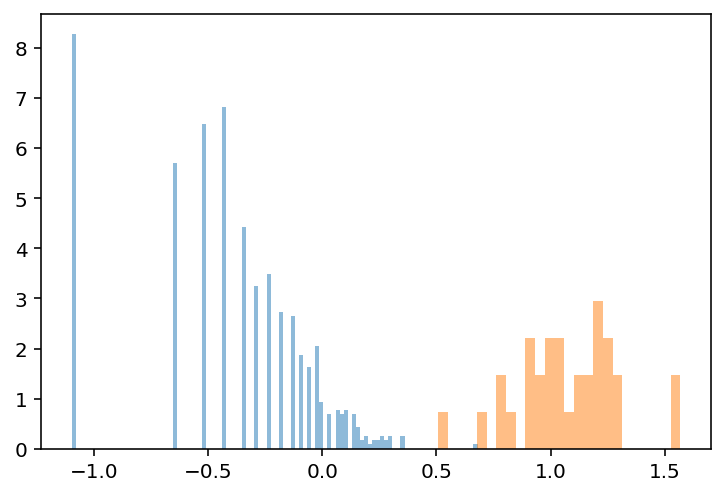

6104


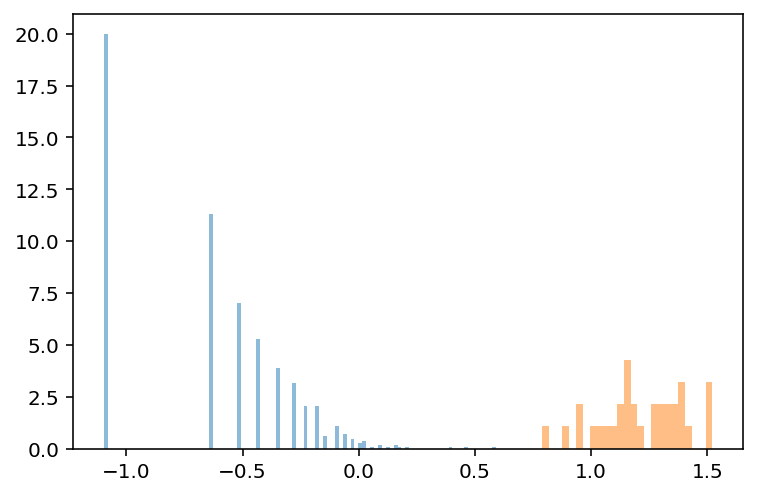

5280


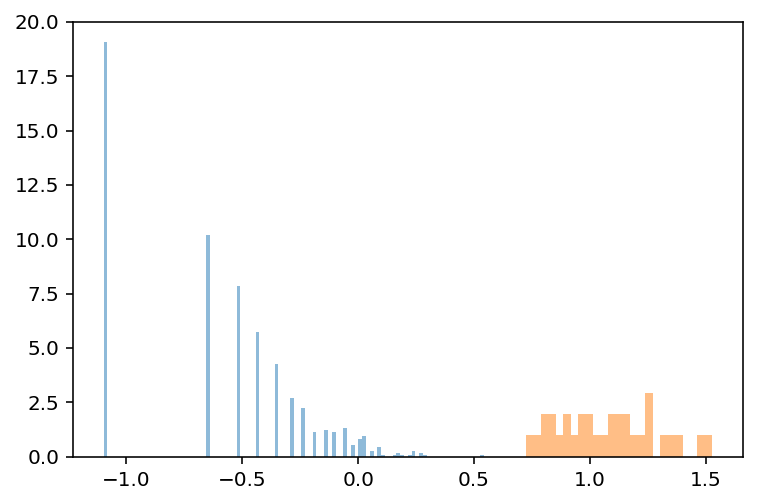

7863


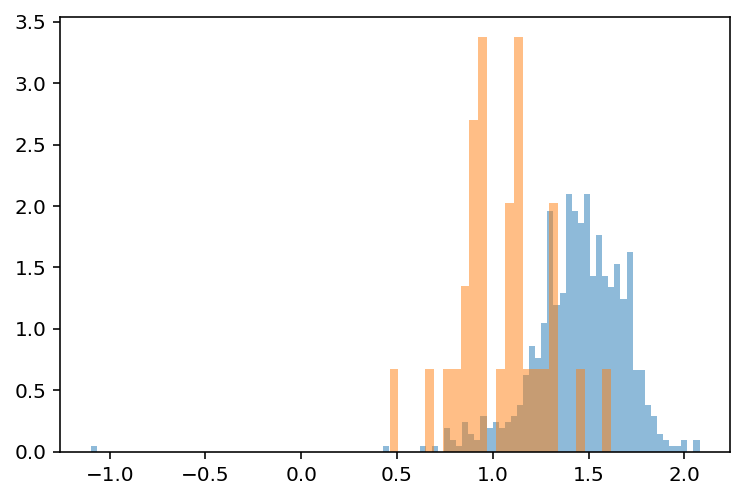

3333


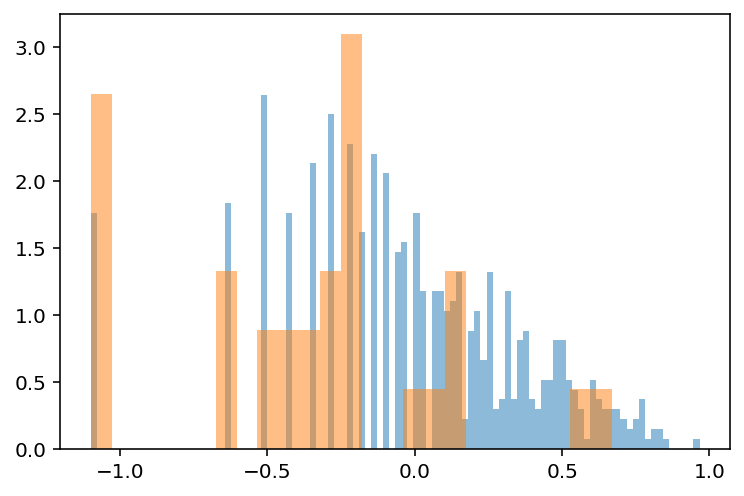

5963


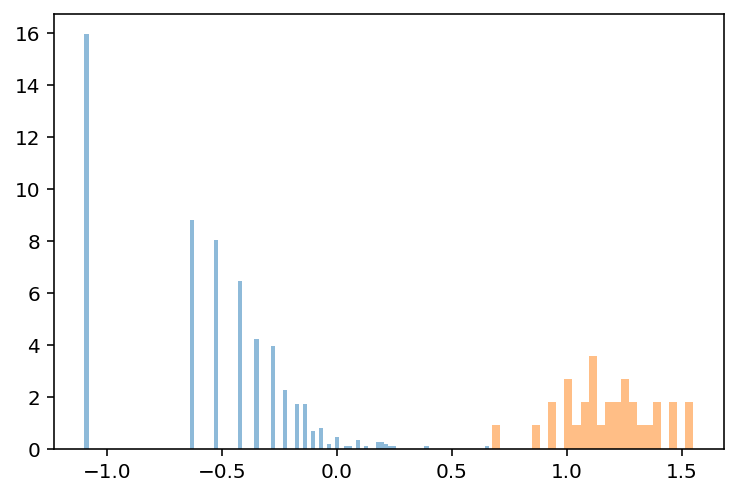

9368


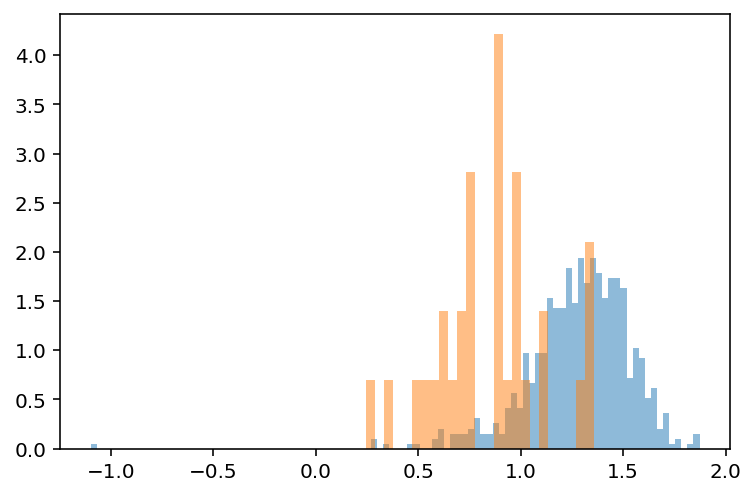

3563


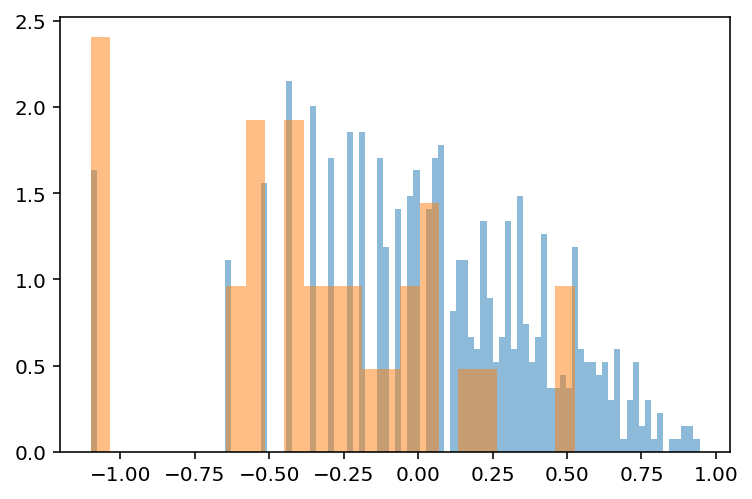

In [ ]:
# norm 3
for i in range(10):
    compare_kmer_plot(rand.randrange(0,km_normed_1.shape[1]))

In [ ]:
# Difference in means per kmer between positive and negative examples
diff_pos_neg = np.mean(positives, axis=0) - np.mean(negatives, axis=0)

0.18171395537183294


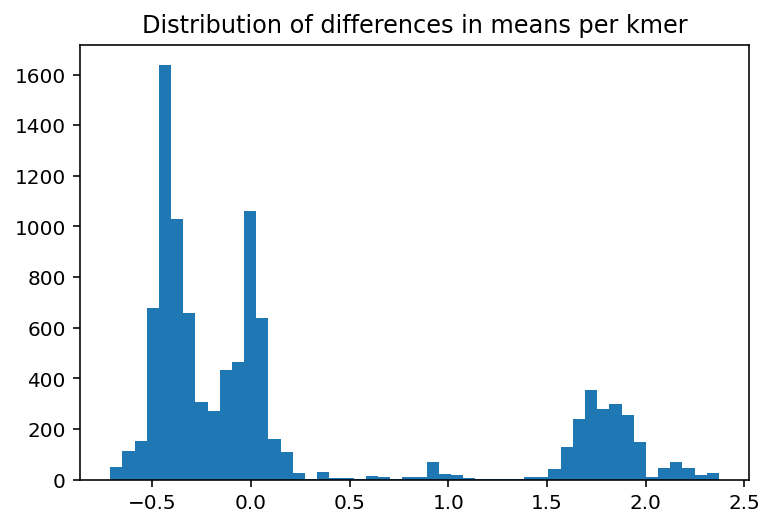

In [ ]:
# Fixed norm_1
print(np.mean(diff_pos_neg))
plt.hist(diff_pos_neg, bins=50)
plt.title("Distribution of differences in means per kmer")
plt.show()

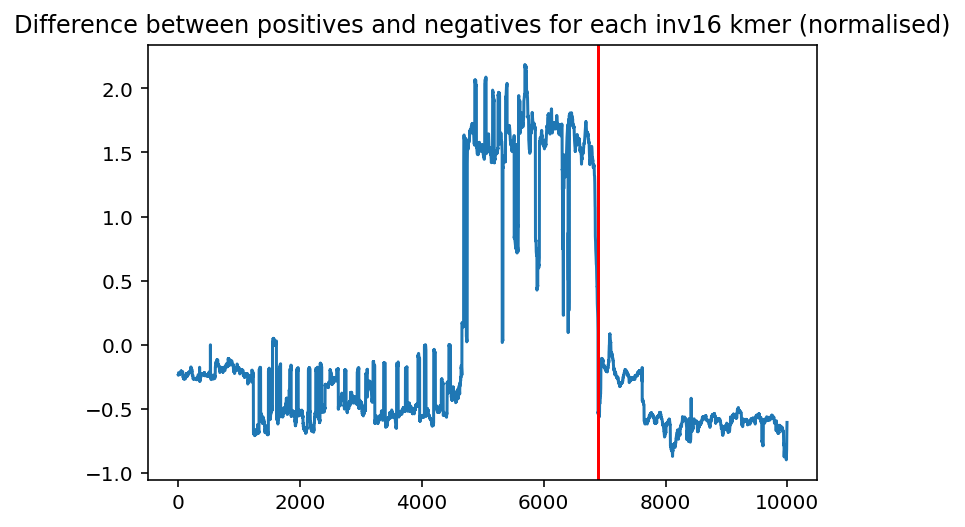

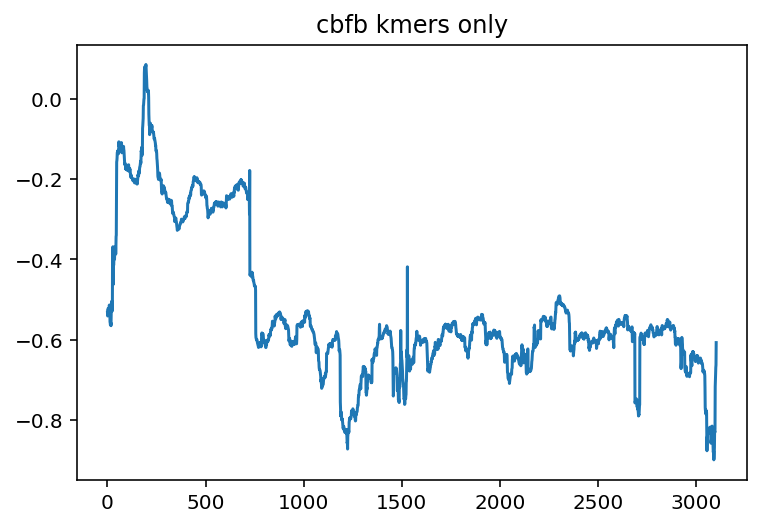

In [ ]:
plt.plot(diff_pos_neg)
plt.title("Difference between positives and negatives for each inv16 kmer (normalised)")
plt.axvline(6891, color='red') # Separation between myh11 and cbfb kmers
plt.show()
plt.plot(diff_pos_neg[6891:])
plt.title("cbfb kmers only")
plt.show()

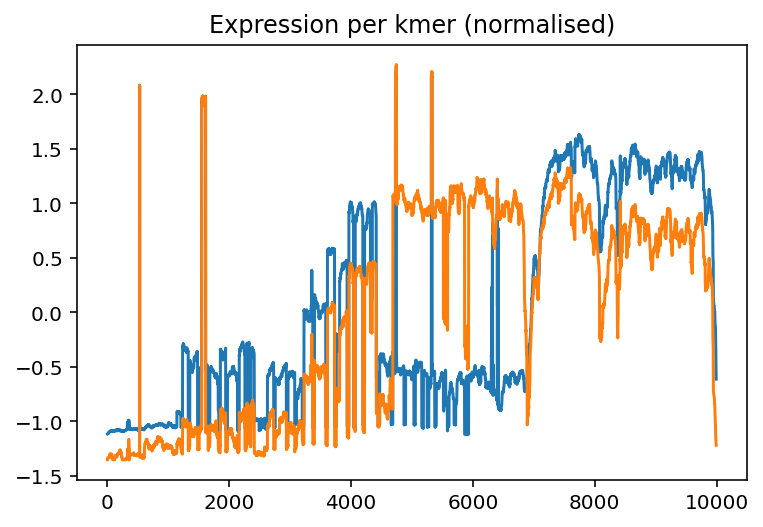

In [ ]:
plt.plot(np.mean(negatives, axis=0))
plt.plot(np.mean(positives, axis=0))
plt.title("Expression per kmer (normalised)")
plt.show()

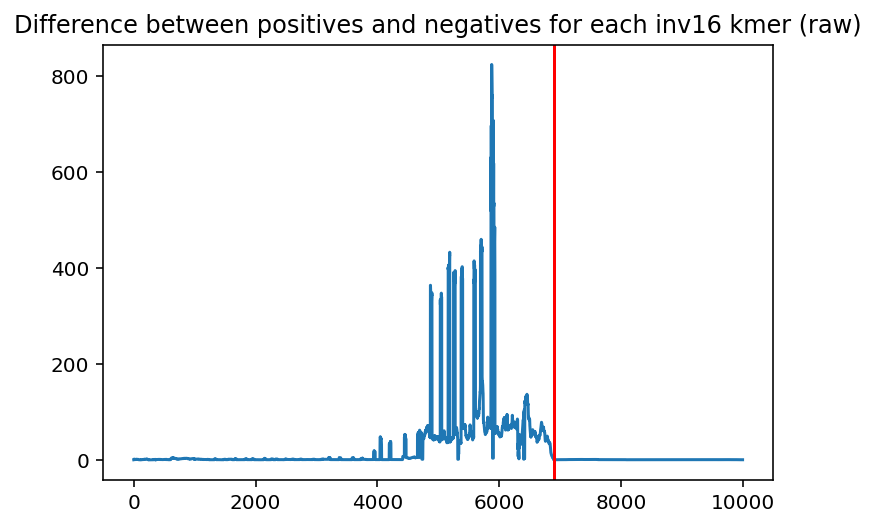

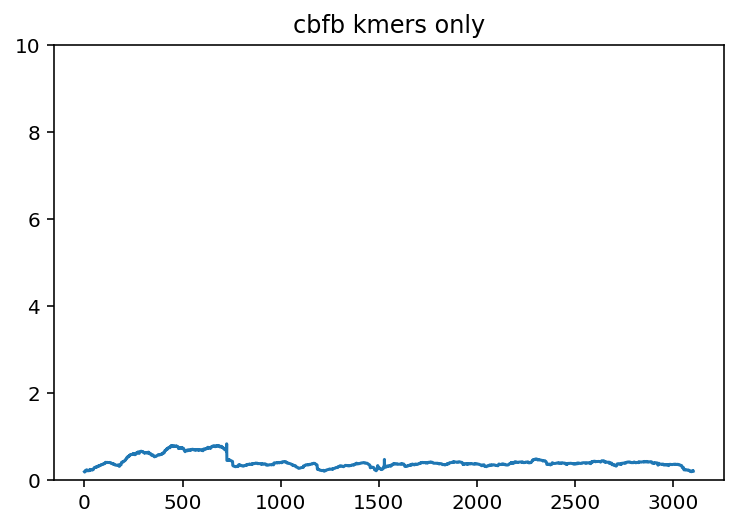

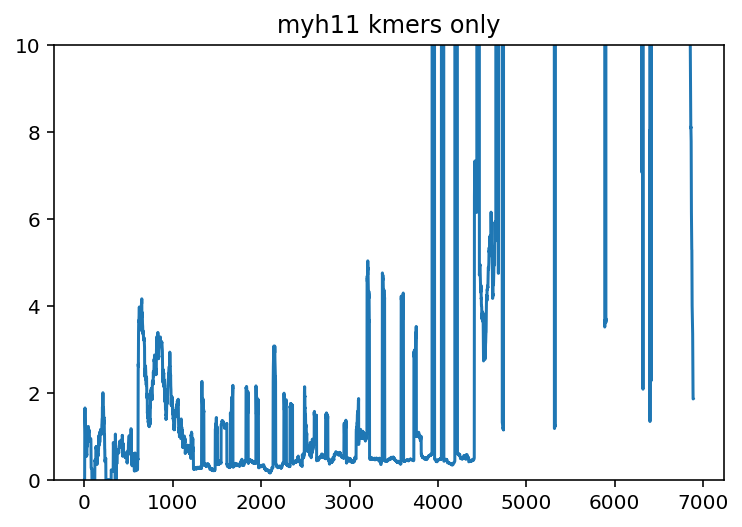

In [ ]:
# Verify from raw data
from inv16_data_loading import kmer_table
from transforms import transform_log10
temp = kmer_table
positives = np.array(temp.iloc[[i for i in range(len(inv_16)) if inv_16[i] == 1]])
negatives = np.array(temp.iloc[[i for i in range(len(inv_16)) if inv_16[i] == 0]])
diff_pos_neg = np.mean(positives, axis=0) / np.mean(negatives, axis=0)
plt.plot(diff_pos_neg)
plt.title("Difference between positives and negatives for each inv16 kmer (raw)")
plt.axvline(6891, color='red') # Separation between myh11 and cbfb kmers
plt.show()
plt.plot(diff_pos_neg[6891:])
plt.title("cbfb kmers only")
plt.ylim(0,10)
plt.show()
plt.plot(diff_pos_neg[:6891])
plt.ylim(0,10)
plt.title("myh11 kmers only")
plt.show()

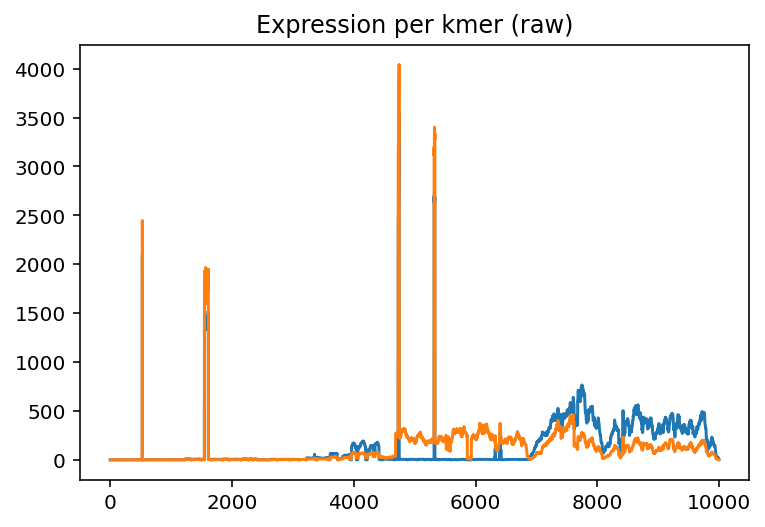

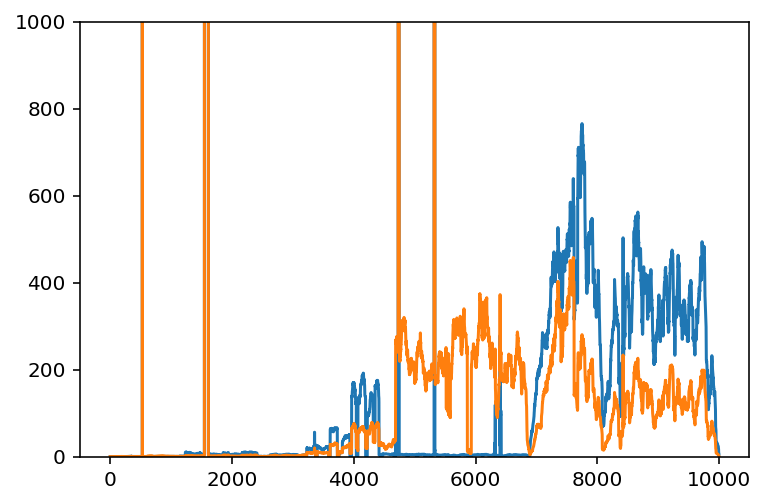

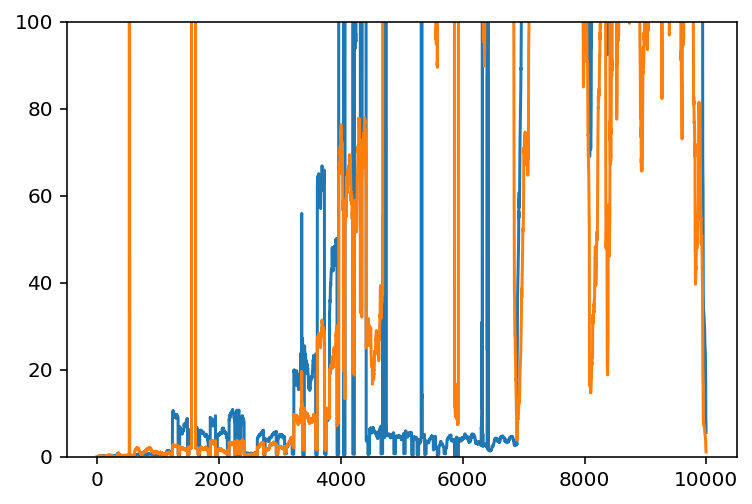

In [ ]:
# Expression per kmer in absolute values
plt.plot(np.mean(negatives, axis=0))
plt.plot(np.mean(positives, axis=0))
plt.title("Expression per kmer (raw)")
plt.show()
plt.plot(np.mean(negatives, axis=0))
plt.plot(np.mean(positives, axis=0))
plt.ylim(0,1000)
plt.show()
plt.plot(np.mean(negatives, axis=0))
plt.plot(np.mean(positives, axis=0))
plt.ylim(0,100)
plt.show()

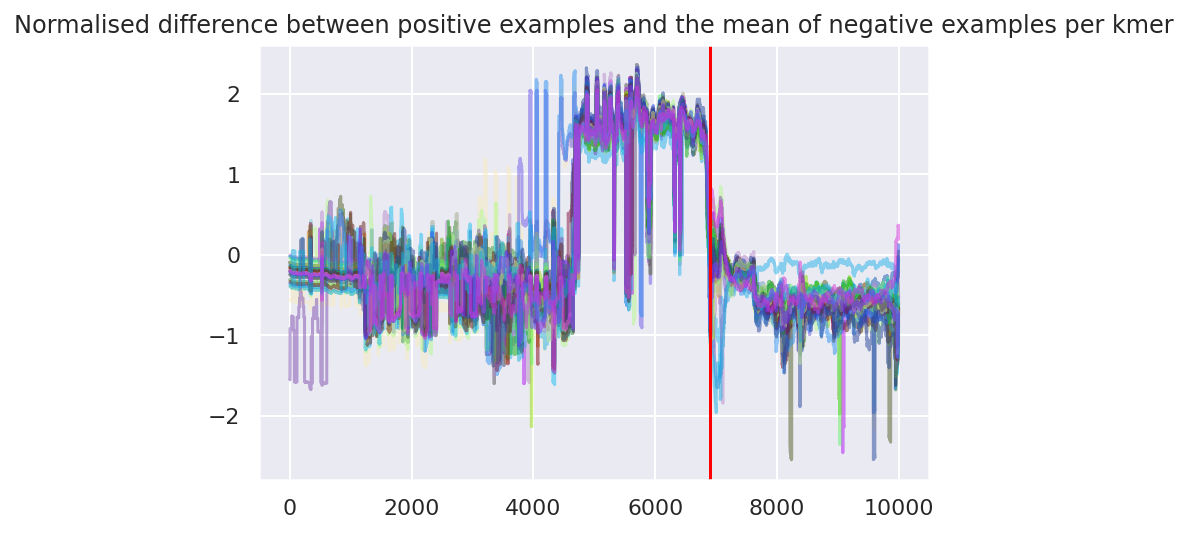

In [ ]:
# Overlapping graph
from inv16_data_loading import km_normed_1, inv_16
pos_indices = [i for i in range(len(inv_16)) if inv_16[i] == 1]
neg_indices = [i for i in range(len(inv_16)) if inv_16[i] == 0]
all_neg = km_normed_1.iloc[neg_indices]
neg_mean = np.mean(all_neg, axis=0)
for pos in pos_indices:
    pos_example = np.array(km_normed_1.iloc[pos])
    diff = np.array(pos_example - neg_mean)
    plt.plot(diff, color=(rand.random(),rand.random(),rand.random(),0.5), label=f"patient_{pos}")
plt.title("Normalised difference between positive examples and the mean of negative examples per kmer")
plt.axvline(6891, color='red') # Separation between myh11 and cbfb kmers
plt.show()

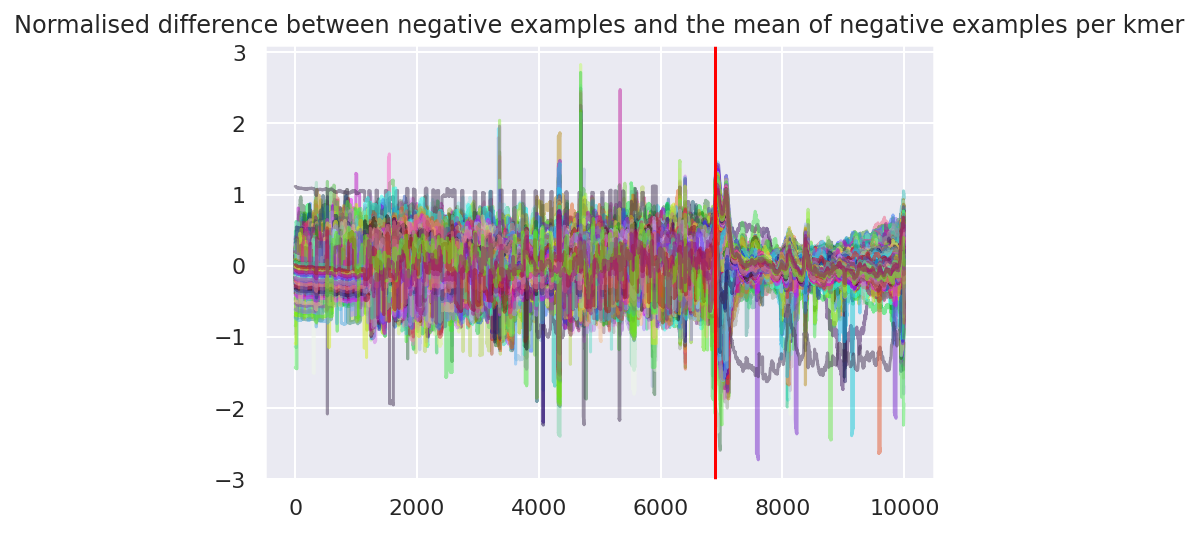

In [ ]:
# Overlapping graph
from inv16_data_loading import km_normed_1, inv_16
pos_indices = [i for i in range(len(inv_16)) if inv_16[i] == 1]
neg_indices = [i for i in range(len(inv_16)) if inv_16[i] == 0]
all_neg = km_normed_1.iloc[neg_indices]
neg_mean = np.mean(all_neg, axis=0)
for neg in neg_indices:
    neg_example = np.array(km_normed_1.iloc[neg])
    diff = np.array(neg_example - neg_mean)
    plt.plot(diff, color=(rand.random(),rand.random(),rand.random(),0.5), label=f"patient_{neg}")
plt.title("Normalised difference between negative examples and the mean of negative examples per kmer")
plt.axvline(6891, color='red') # Separation between myh11 and cbfb kmers
plt.show()

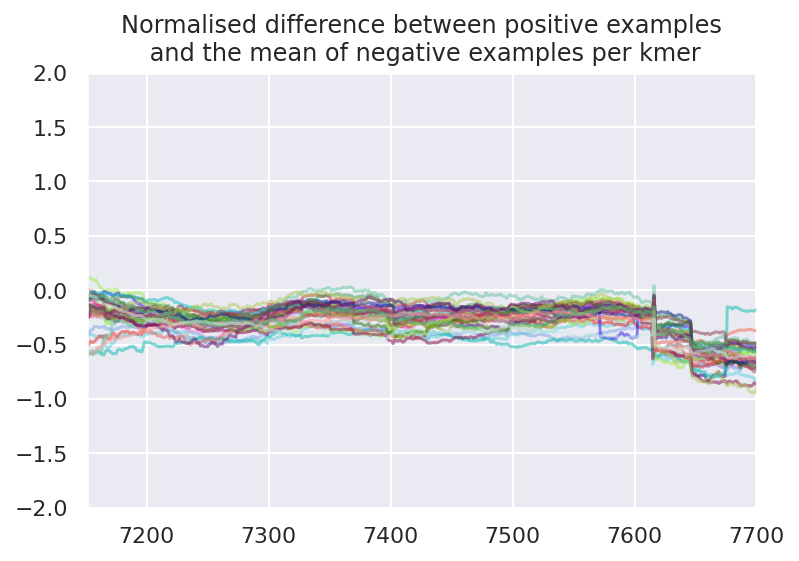

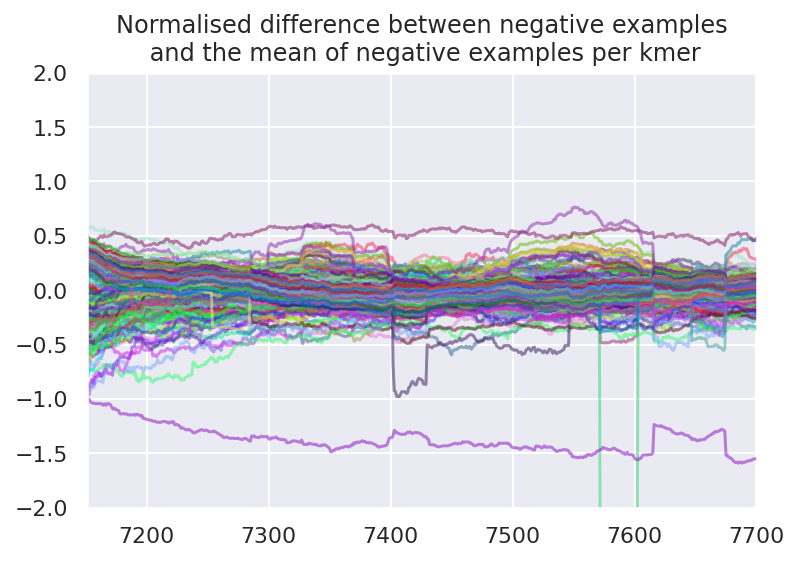

In [ ]:
# Zoomed in on CDS of cbfb
from inv16_data_loading import km_normed_1, inv_16
sns.set()
pos_indices = [i for i in range(len(inv_16)) if inv_16[i] == 1]
neg_indices = [i for i in range(len(inv_16)) if inv_16[i] == 0]
all_neg = km_normed_1.iloc[neg_indices]
neg_mean = np.mean(all_neg, axis=0)
for pos in pos_indices:
    pos_example = np.array(km_normed_1.iloc[pos])
    diff = np.array(pos_example - neg_mean)
    plt.plot(diff, color=(rand.random(),rand.random(),rand.random(),0.5), label=f"patient_{pos}")
plt.title("Normalised difference between positive examples\n and the mean of negative examples per kmer")
plt.xlim(6891+260, 6891+809)
plt.ylim(-2, 2)
plt.show()
for neg in neg_indices:
    neg_example = np.array(km_normed_1.iloc[neg])
    diff = np.array(neg_example - neg_mean)
    plt.plot(diff, color=(rand.random(),rand.random(),rand.random(),0.5), label=f"patient_{neg}")
plt.title("Normalised difference between negative examples\n and the mean of negative examples per kmer")
plt.xlim(6891+260, 6891+809)
plt.ylim(-2, 2)
plt.show()

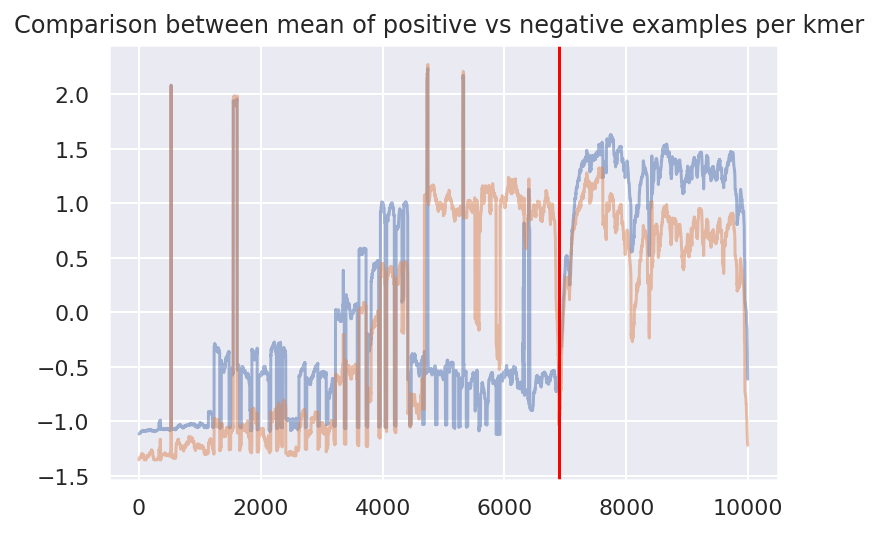

In [ ]:
# Mean of negatives and mean of positives
mean_neg = np.array(np.mean(km_normed_1.iloc[neg_indices], axis=0))
mean_pos = np.array(np.mean(km_normed_1.iloc[pos_indices], axis=0))
plt.plot(mean_neg, alpha=0.5)
plt.plot(mean_pos, alpha=0.5)
plt.title("Comparison between mean of positive vs negative examples per kmer ")
plt.axvline(6891, color='red') # Separation between myh11 and cbfb kmers
plt.show()

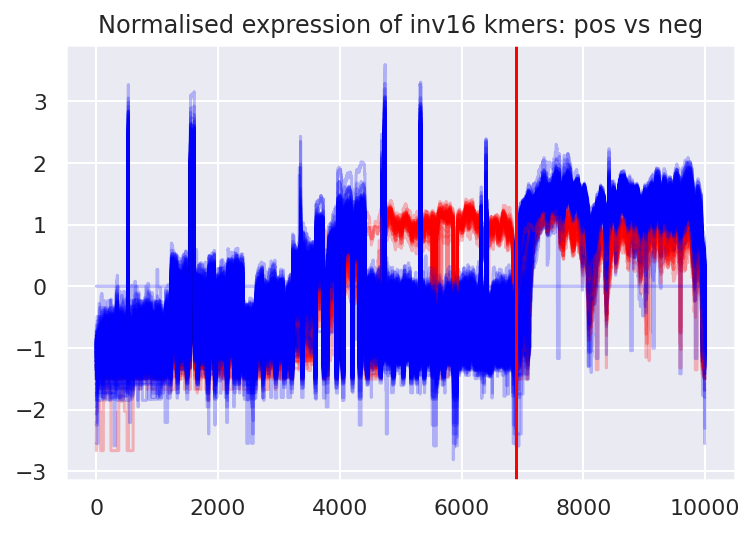

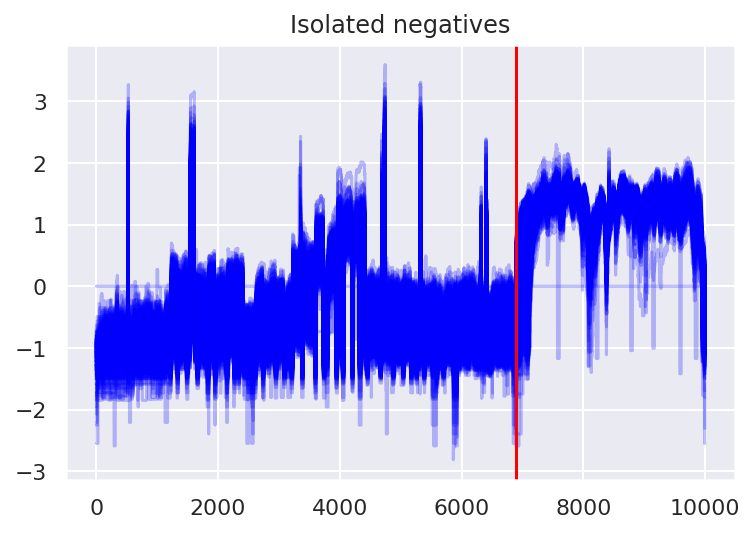

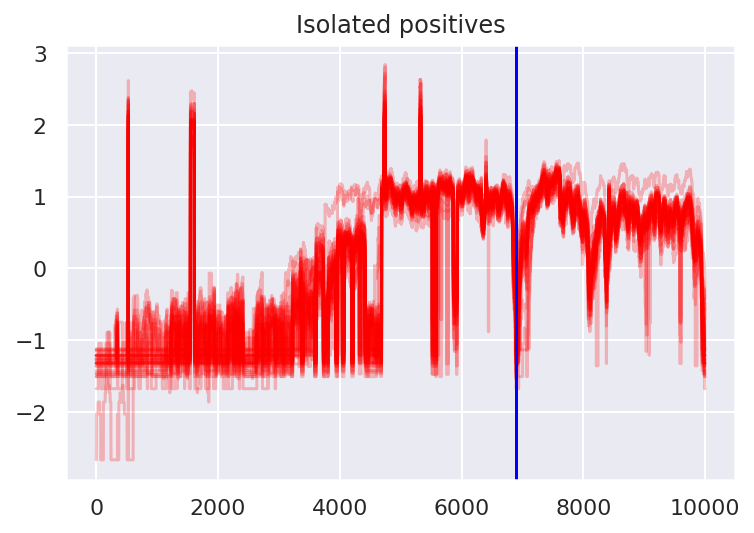

In [ ]:
# Overlap graph of normalised expression
for i in range(len(km_normed_1)):
    if inv_16[i] == 0:
        plt.plot(np.array(km_normed_1.iloc[i]), color='blue', alpha=0.25)
    elif inv_16[i] == 1:
        plt.plot(np.array(km_normed_1.iloc[i]), color='red', alpha=0.25)
plt.title("Normalised expression of inv16 kmers: pos vs neg")
plt.axvline(6891, color='red') # Separation between myh11 and cbfb kmers
plt.show()
for i in range(len(km_normed_1)):
    if inv_16[i] == 0:
        plt.plot(np.array(km_normed_1.iloc[i]), color='blue', alpha=0.25)
plt.title("Isolated negatives")
plt.axvline(6891, color='red') # Separation between myh11 and cbfb kmers
plt.show()
for i in range(len(km_normed_1)):
    if inv_16[i] == 1:
        plt.plot(np.array(km_normed_1.iloc[i]), color='red', alpha=0.25)
plt.title("Isolated positives")
plt.axvline(6891, color='blue') # Separation between myh11 and cbfb kmers
plt.show()

### Checking that sets are separate



In [ ]:
tag = []
for pat in data:
    tag.append(pat[0][-1])
from collections import Counter
counter = Counter()
for t in tag:
    counter[t] += 1

In [ ]:
t_set, v_set = set(), set()
for ti in train_idx:
    t_set.add(int(tag[ti]))
for vi in valid_idx:
    v_set.add(int(tag[vi]))
print(t_set.intersection(v_set))
print(len(t_set))
print(len(v_set))

set()
552
139


In [ ]:
t_set, v_set = set(), set()
for d, t in train_loader:
    for line in d:
        t_set.add(int(line[-1]))
for d, t in valid_loader:
    for line in d:
        v_set.add(int(line[-1]))
print(t_set.intersection(v_set))
print(len(t_set))
print(len(v_set))

set()
552
139


In [ ]:
np.array(sorted(list(t_set))) == np.array(sorted(list(train_idx)[:552]))

In [ ]:
len(valid_idx)

264

In [ ]:
print(len(train_idx), len(valid_idx))
print(sum(oc_inv_16) / len(oc_inv_16))

1054 264
0.5


In [ ]:
# Ensuring separate sets
print(set(pos_train).intersection(set(pos_val)))
print(set(neg_train).intersection(set(neg_val)))
print(set(pos_train).intersection(set(neg_val)))
print(set(pos_train).intersection(set(neg_train)))
print(set(pos_val).intersection(set(neg_val)))
print(set([1, 2, 3, 4, 5]).intersection(set([0, 3, 6, 7, 1])))

set()
set()
set()
set()
set()
{1, 3}


### Debugging

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def remove_tag(data, s):
    # taking out tag
    print(f"New {s} batch!")
    tags = [chr(i) for i in data[:,-1]]
    print(" ".join(tags))
    return data[:,:-1]

In [ ]:
%pdb

Automatic pdb calling has been turned OFF


### Running model

In [ ]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

# 4 layers sgd lr=0.01 and no dropout
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 8)
        self.fc5 = nn.Linear(8, 2)
        #self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        x = F.relu(self.fc4(x))
        #x = self.dropout(x)
        x = self.fc5(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 100
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data.float())
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data.float())
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_inv16_3.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch+1}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
print("")
torch.save(model.state_dict(), 'model_files/model_inv16_3.pt')

# Final model
# model.load_state_dict(torch.load('model_files/model_inv16_3.pt'))
# from sklearn.metrics import roc_auc_score
# model.eval()
# score = 0
# for data, target in test_loader:
#     data = data.to(device)
#     pred = model.predict(data.float())
#     pred.cpu()
#     score += roc_auc_score(pred, target)*len(target)
#     # print(pred)
#     # print(target)
#     # print(roc_auc_score(pred, target))
# print('\n', score/len(test_loader.sampler))

# Saved best model
# model.load_state_dict(torch.load('model_files/model_inv16_3.pt'))
# model.eval()
# score = 0
# for data, target in test_loader:
#     data = data.to(device)
#     data.float()
#     pred = model.predict(data.float())
#     pred.cpu()
#     score += roc_auc_score(pred, target)*len(target)
#     # print(pred)
#     # print(target)
#     # print(roc_auc_score(pred, target))
# print('\n', score/len(test_loader.sampler))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()

Epoch: 472	Train: 8.343819389344702e-05	Val: 8.68063214485132e-05	Min Val: 8.68063214485132e-05

KeyboardInterrupt: ignored

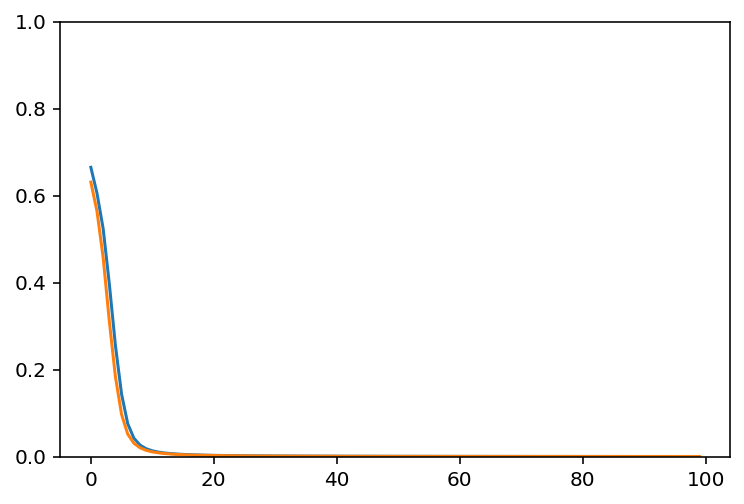

In [ ]:
# Original result
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()

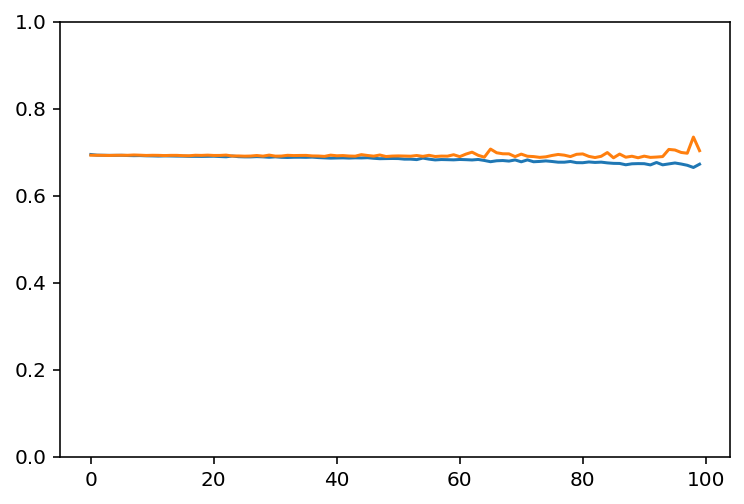

In [ ]:
# Shuffling after oversampling (all 0)
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()

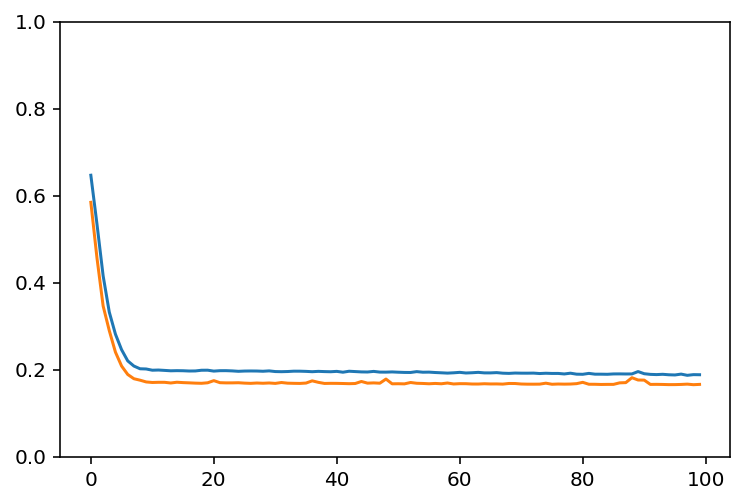

In [ ]:
# Shuffling after splitting (0.94 ROCAUC)
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()

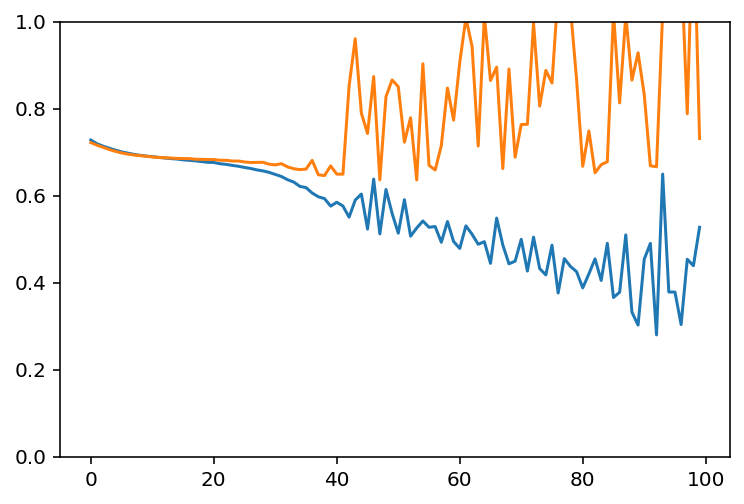

In [ ]:
# Shuffling at the beginning (only predicts 0)
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()
# put systematic testing inside a table
# with and without everything, shuffle at various places, run code with random shuffles multiple times
# Organize the code